In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

In [28]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

### Read in cleaned dataset  
To obtain station list sorted by numbers of samples

In [29]:
df = pd.read_csv('../../dataset/final/bentre-cleaned.csv', parse_dates=['date'])

In [30]:
# number of stations
station_count = df['code'].value_counts()

station_count

SONDOC             2271
LOCTHUAN           2154
BINHDAI            2108
BENTRAI            2108
ANTHUAN            2108
MYHOA               308
TICHTHIEN           302
MOCAY               302
PHUOCLONG           302
TANTHIENG           302
TIENTHUY            302
GIAOHOA             182
THANHTHOIA          151
VUNGLIEM            151
BENCHUA             151
CAMSON              151
MYVAN               151
CAIMIT              151
CONGNANGAM          151
RACHRUM             151
CAIHOP              151
SONPHU              151
LANGTHE             151
VANGQUOITAY         151
HUNGKHANHTRUNGB     151
MYTHANH             151
TRACU               151
HUONGMY              92
Name: code, dtype: int64

In [31]:
df.set_index('date', inplace=True)

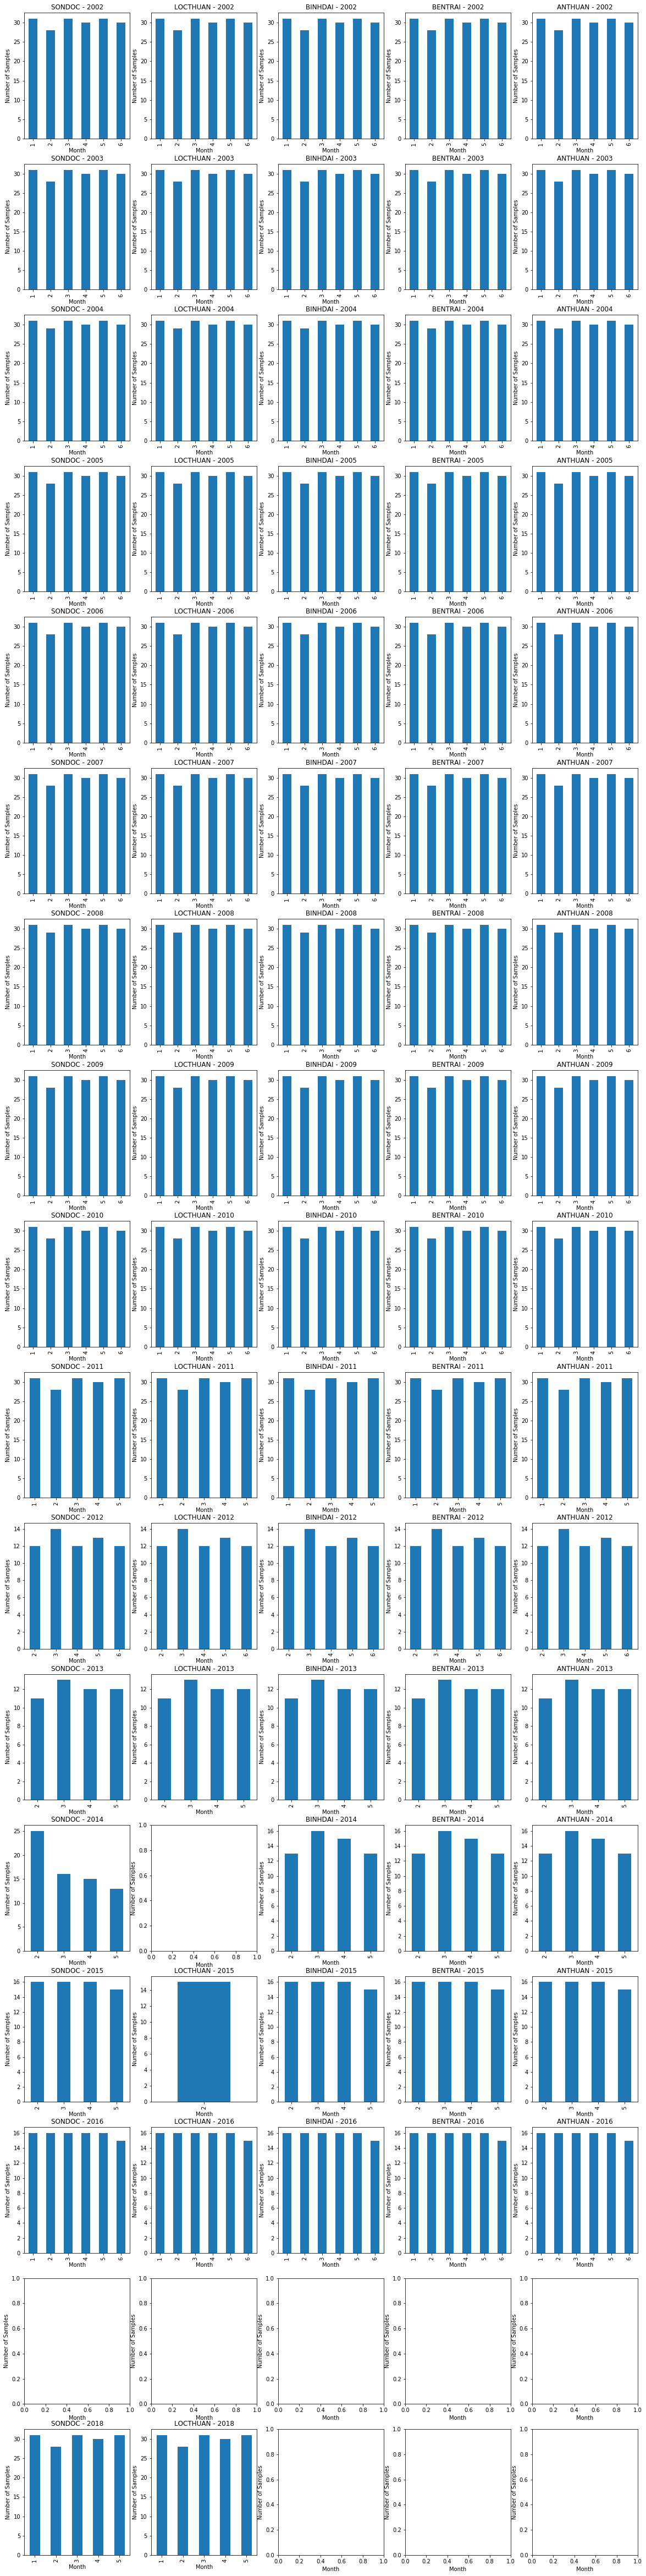

In [32]:
nrows = 2019 - 2002
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

for row in range(nrows):
    year = 2002 + row
    
    for col in range(ncols):
        ax = axes[row, col]
        station = station_count.index[col]
        
        temp_df = df[(df.index.year == year) & (df['code'] == station)]
        if temp_df.shape[0] > 0:
            temp_df.groupby(temp_df.index.month).count()['max'].plot.bar(ax=ax, title=f'{station} - {year}');
            
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Samples')

### Load 2002 - 2010 samples from top 5 stations

Only top 5 stations have full sample each month and spreaded from Jan to Jun

In [134]:
start_year = 2002
end_year = 2010

In [33]:
# where all CSV files are
input_path = '../../dataset/final/stations'

In [34]:
def read_csv(filename):
    return pd.read_csv(filename, usecols=['date', 'code', 'min', 'max'], index_col='date', parse_dates=['date'])

Trial with station SONDOC first

In [35]:
station_code = 'SONDOC'

In [36]:
station_df = read_csv(f'{input_path}/{station_code}.csv')

In [37]:
station_df.index.freq = 'D'

In [38]:
station_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq='D')

In [39]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6209 entries, 2002-01-01 to 2018-12-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    6209 non-null   object 
 1   min     6209 non-null   float64
 2   max     6209 non-null   float64
dtypes: float64(2), object(1)
memory usage: 194.0+ KB


In [40]:
station_df.sort_index(inplace=True)

In [41]:
station_df.head()

,code,min,max
date,,,
2002-01-01,SONDOC,0.10000,0.30000
2002-01-02,SONDOC,0.10000,0.40000
2002-01-03,SONDOC,0.20000,0.40000
2002-01-04,SONDOC,0.20000,0.50000
2002-01-05,SONDOC,0.10000,0.60000


In [42]:
station_df.tail()

,code,min,max
date,,,
2018-12-27,SONDOC,0.01000,0.01000
2018-12-28,SONDOC,0.01000,0.01000
2018-12-29,SONDOC,0.01000,0.01000
2018-12-30,SONDOC,0.01000,0.01000
2018-12-31,SONDOC,0.01000,0.01000


Simulate 2nd half of the year data, Jan -> Dec, Feb -> Nov, ..., Jun -> Jul

In [163]:
def replicate_season(data, code):
    temp_df = pd.DataFrame()

    for year in range(start_year, end_year + 1):
        temp1_df = data[f'{year}-01-01':f'{year}-06-30']

        for month in range(1, 7):
            temp2_df = data[(data.index.year == year) & (data.index.month == month)]

            temp2_df.reset_index(inplace=True)
            temp2_df = pd.concat([pd.DataFrame(
                {
                    'date': pd.date_range(start=f"{year}-{13 - month}-{row['date'].day}", periods=1, freq='D'),
                    'code': row['code'],
                    'min': row['min'],
                    'max': row['max']
                }, 
                columns=['date', 'code', 'min', 'max']
                ) for i, row in temp2_df.iterrows()
              ], 
              ignore_index=True
             )

            temp2_df.set_index('date', inplace=True)
            temp1_df = pd.concat([temp1_df, temp2_df])

        
        temp_df = pd.concat([temp_df, temp1_df])
 

    # sort by date because Dec was appended first, then Nov, and so on
    temp_df.sort_index(inplace=True)
    
    # prepare and fill missing date (Jul 31, Nov 29 and Nov 30)
    date_range = pd.date_range(start=temp_df.index.min(), end=temp_df.index.max(), freq='D')
    temp_df = train_df.reindex(date_range).fillna(np.nan).rename_axis('date').reset_index()
    
    # set station for new dates
    temp_df['code'] = code
    
    # interpolate min and max
    temp_df.set_index('date', inplace=True)
    temp_df.interpolate(method ='time', limit_direction ='forward', inplace=True)
    
    # now daily frequent can be set
    temp_df.index.freq = 'D'
    
    # return
    return temp_df

In [164]:
train_df = replicate_season(station_df, station_code)

In [165]:
train_df.to_csv(f'../../dataset/final/tops/{station_code}.csv', index=True, index_label='date')

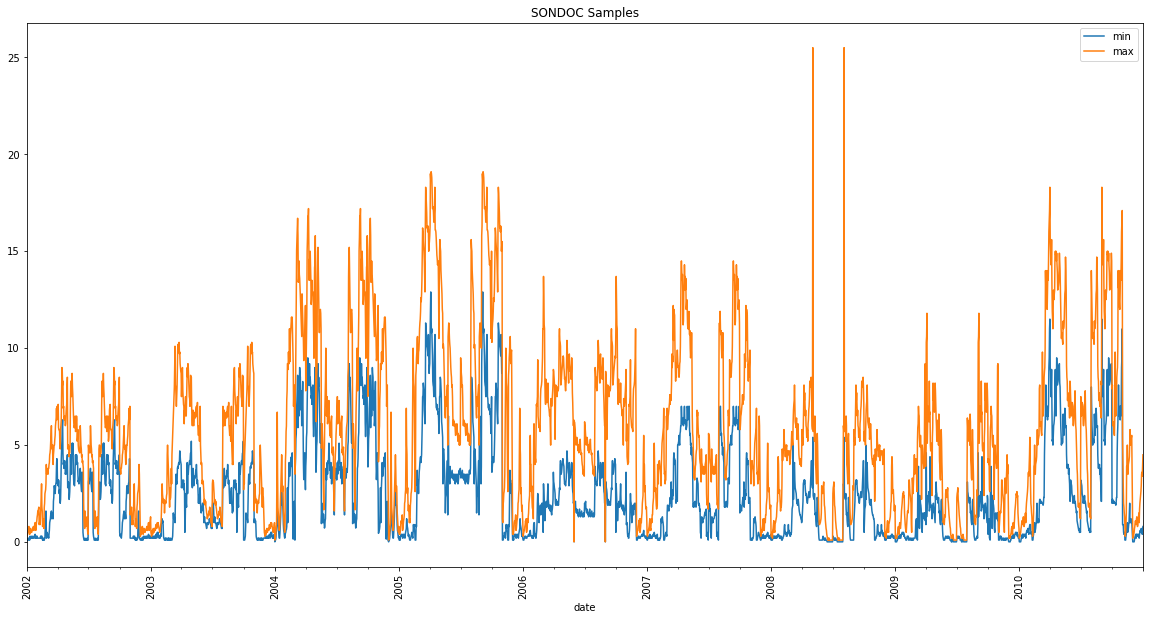

In [167]:
train_df.plot(title=f'{station_code} Samples', rot=90, figsize=(20, 10));

### Verify ARIMA requirements

In [185]:
value_field = 'max'
season_length = 365

In [169]:
train_data = train_df['max']

In [171]:
from statsmodels.tsa.seasonal import seasonal_decompose

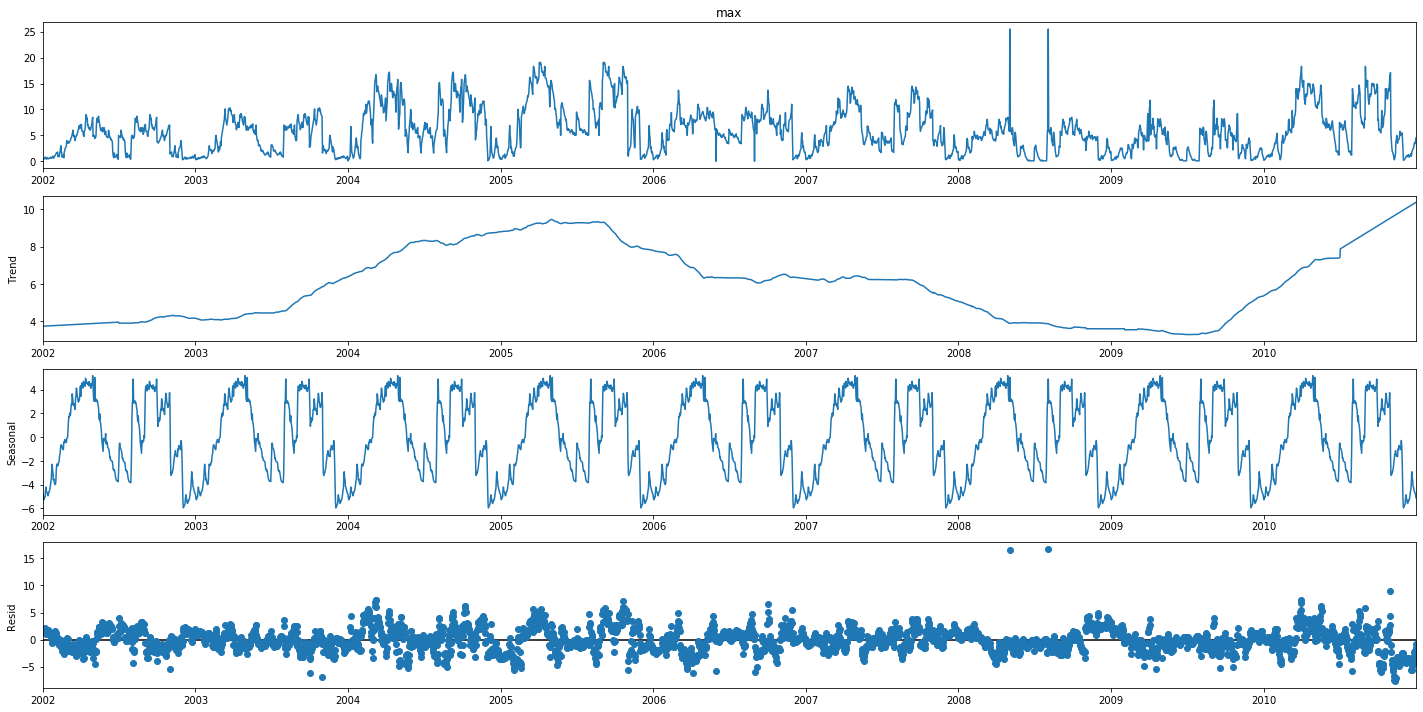

In [186]:
# option 1 to set figsize for plot() used by seasonal_decompose()
plt.rcParams['figure.figsize'] = (20, 10)

p = seasonal_decompose(train_data, model='additive', period=season_length, extrapolate_trend=season_length).plot();

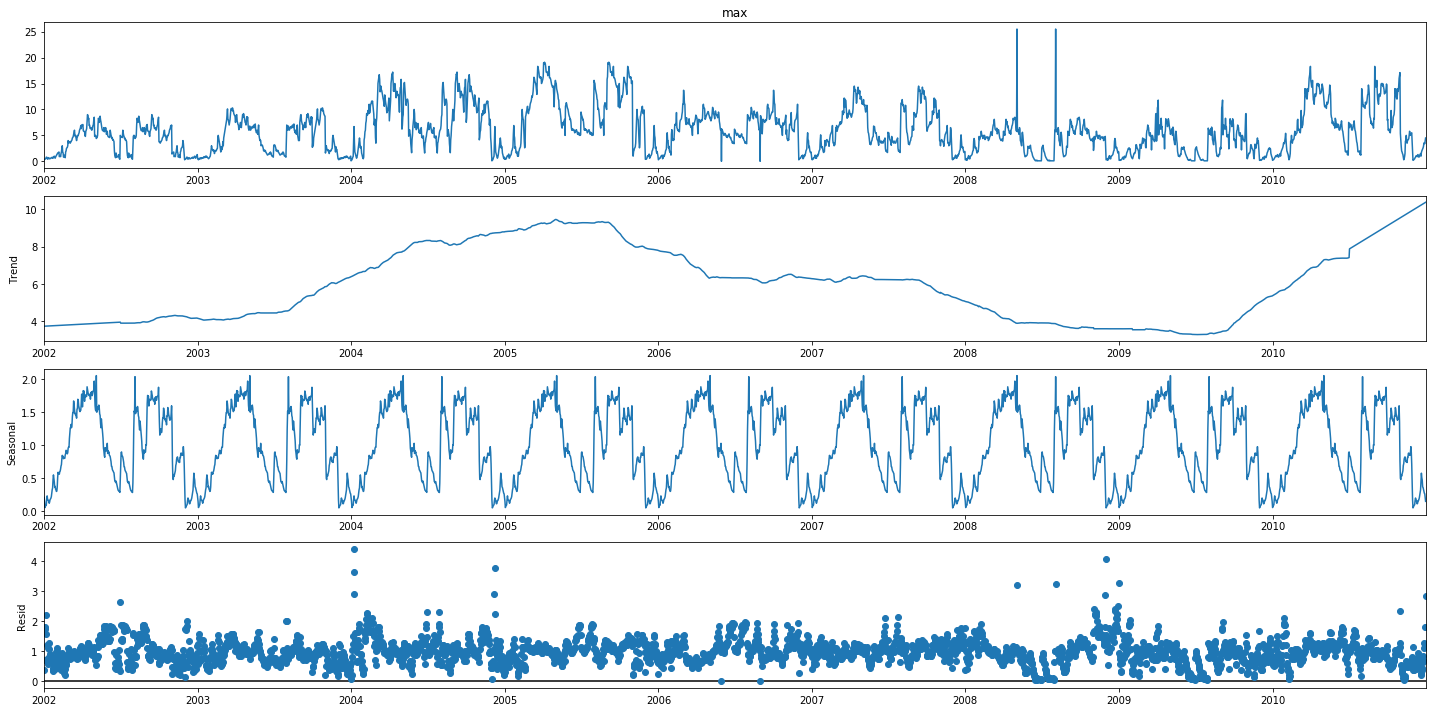

In [191]:
p = seasonal_decompose(train_data, model='multiplicative', period=season_length, extrapolate_trend=season_length).plot()

# option 2 to set figsize for plot() used by seasonal_decompose()
fig.set_size_inches(20, 10);

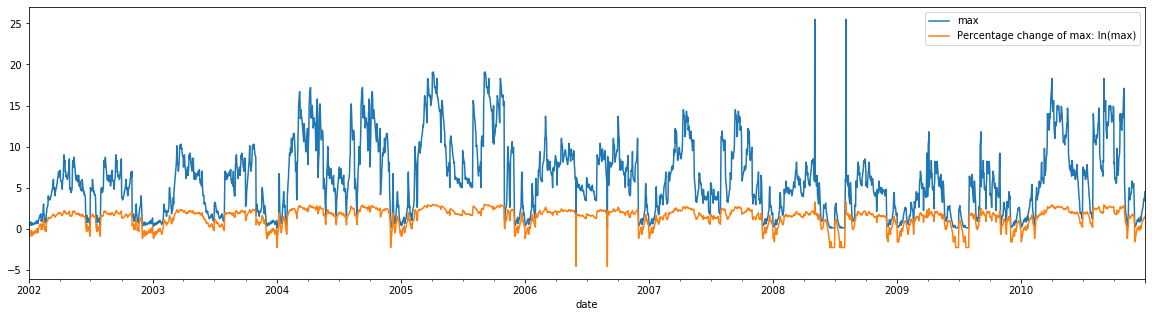

In [192]:
# Visualize value changes (percentage)
col = f'Percentage change of {value_field}: ln({value_field})'
temp_df[col] = np.log(train_data)
temp_df[[value_field, col]].plot(figsize=(20, 5));

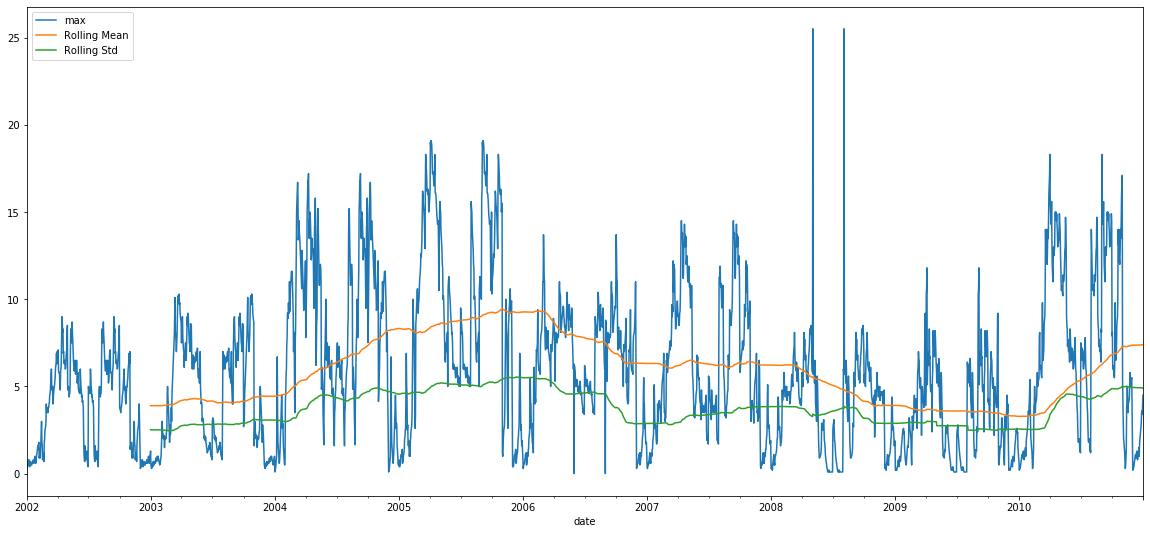

In [194]:
# SMA - Simple Moving Average
train_data.plot(figsize=(20, 9))
temp_df[value_field].rolling(window=season_length).mean().plot(figsize=(20, 9), label='Rolling Mean')
temp_df[value_field].rolling(window=season_length).std().plot(figsize=(20, 9), label='Rolling Std')
plt.legend(loc='upper left');

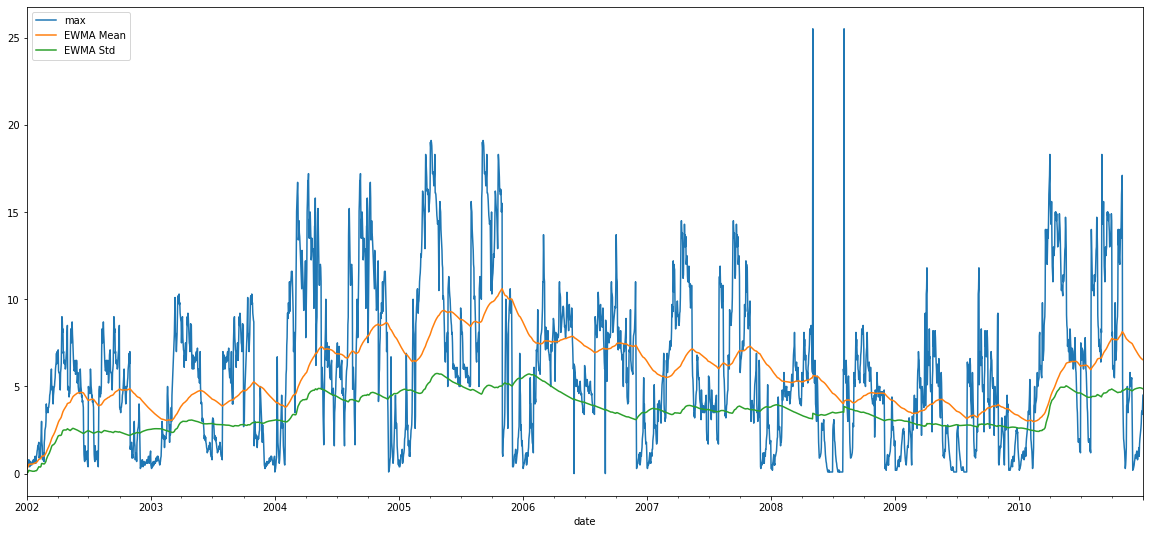

In [195]:
# EWMA - Exponentially-weighted moving average
temp_df[value_field].plot(figsize=(20, 9))
temp_df[value_field].ewm(span=season_length).mean().plot(figsize=(20, 9), label='EWMA Mean')
temp_df[value_field].ewm(span=season_length).std().plot(figsize=(20, 9), label='EWMA Std')
plt.legend(loc='upper left');

In [196]:
from statsmodels.tsa.stattools import adfuller

In [201]:
# Augmented Dickey-Fuller Test
def adf_check(df, code, field):
    temp_df = df[(df['code'] == code) & (df.index.year <= end_year)]
    temp_df.index.freq = 'D'
    
    result = adfuller(temp_df[field], autolag='AIC')

    print(f'Augmented Dickey-Fuller Test of Station {code} on field {field}:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    
    if result[1] <= 0.05:
        print(f'{field} of station {code} is stationary!!!')
    else:
        print(f'{field} of station {code} is NON-STATIONARY :(')

In [202]:
adf_check(train_df, station_code, value_field)

Augmented Dickey-Fuller Test of Station SONDOC on field max:
ADF Test Statistic: -4.048357143422186
p-value: 0.001177426575819273
#Lags Used: 27
Number of Observations Used: 3259
max of station SONDOC is stationary!!!


### Granger Causality Tests

In [204]:
from statsmodels.tsa.stattools import grangercausalitytests

### Autocovariance, Autocorrelation, and Partial Autocorrelation

In [203]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

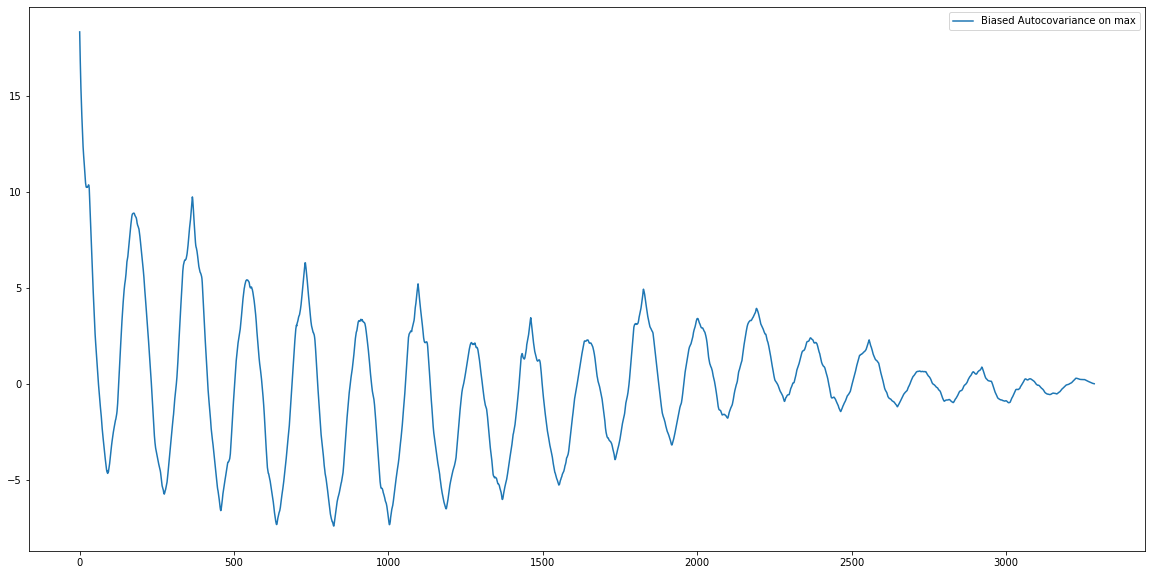

In [206]:
# Biased Autocovariance
plt.plot(acovf(train_data, fft=True), label='Biased Autocovariance on max')
plt.legend();

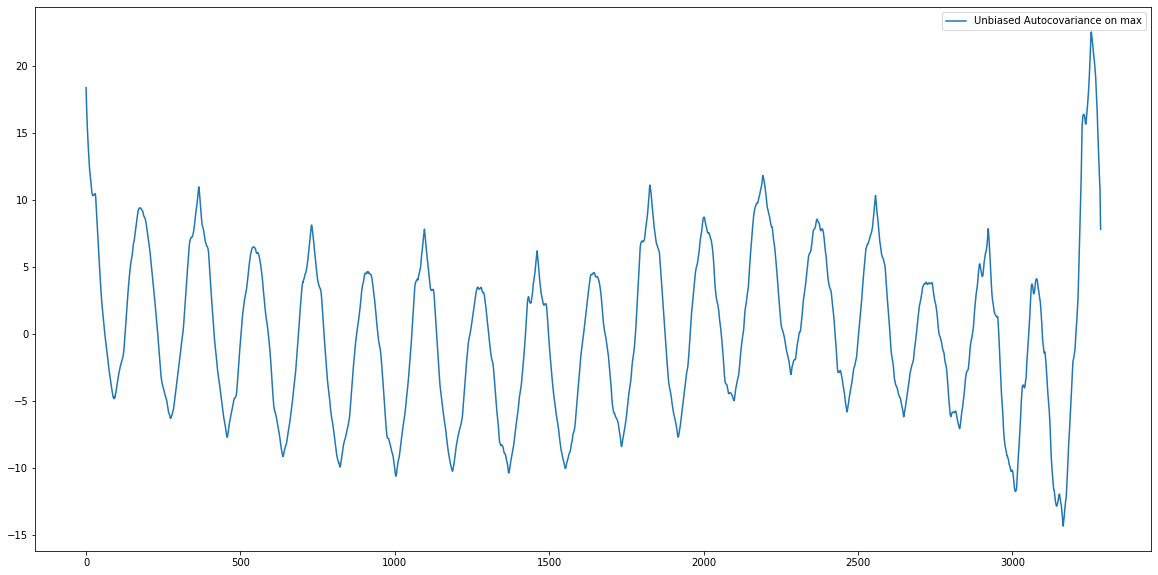

In [207]:
# Unbiased Autocovariance
plt.plot(acovf(train_data, fft=True, unbiased=True), label='Unbiased Autocovariance on max')
plt.legend();

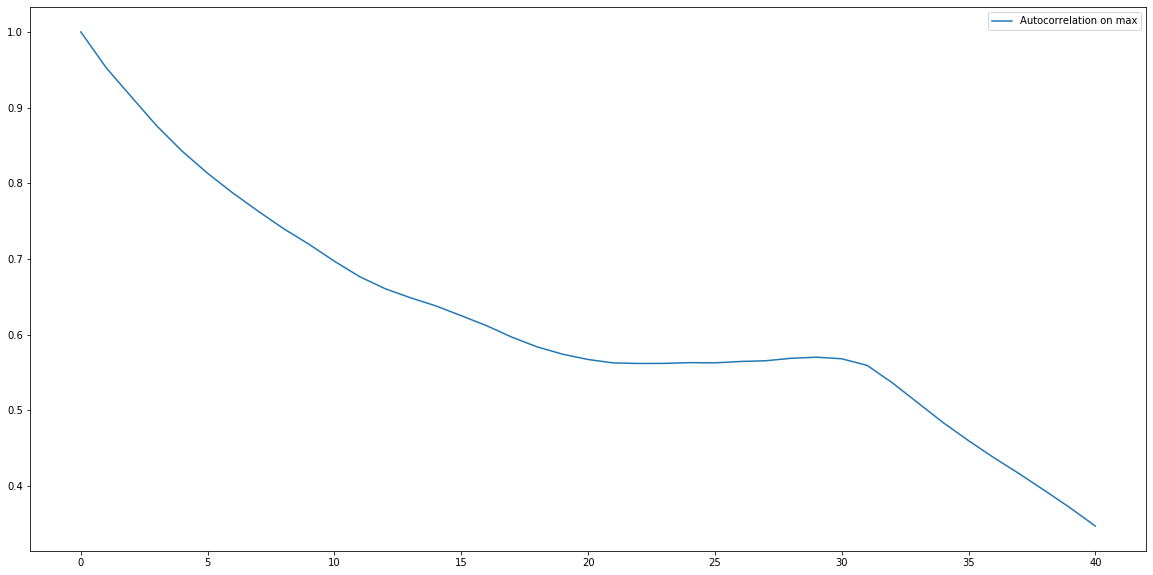

In [208]:
# Autocorrelation
plt.plot(acf(train_data, fft=True, unbiased=True), label='Autocorrelation on max')
plt.legend();

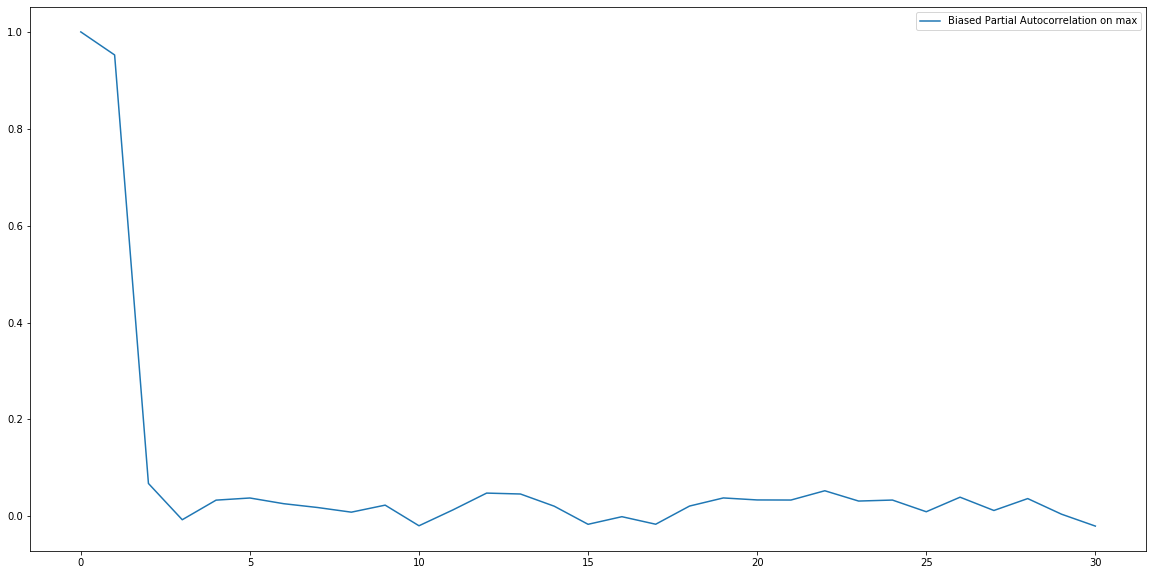

In [209]:
# Biased Partial Autocorrelation using 'mle' - maximum likelihood estimation - with Yule-Walker
plt.plot(pacf_yw(train_data, nlags=30, method='mle'), label='Biased Partial Autocorrelation on max')
plt.legend();

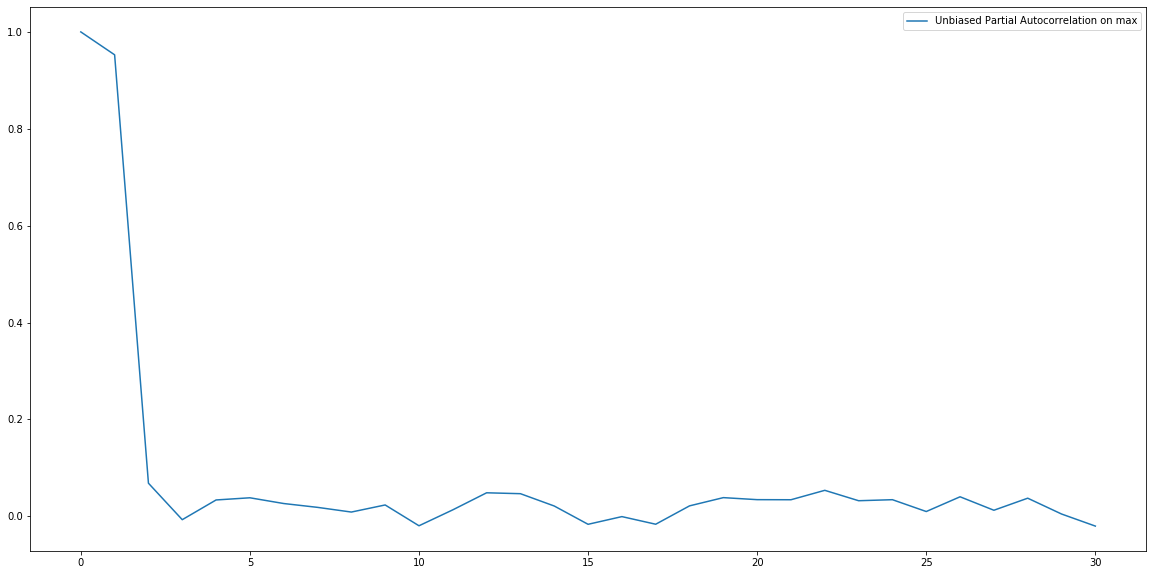

In [210]:
# Unbiased Partial Autocorrelation
plt.plot(pacf_yw(train_data, nlags=30, method='unbiased'), label='Unbiased Partial Autocorrelation on max')
plt.legend();

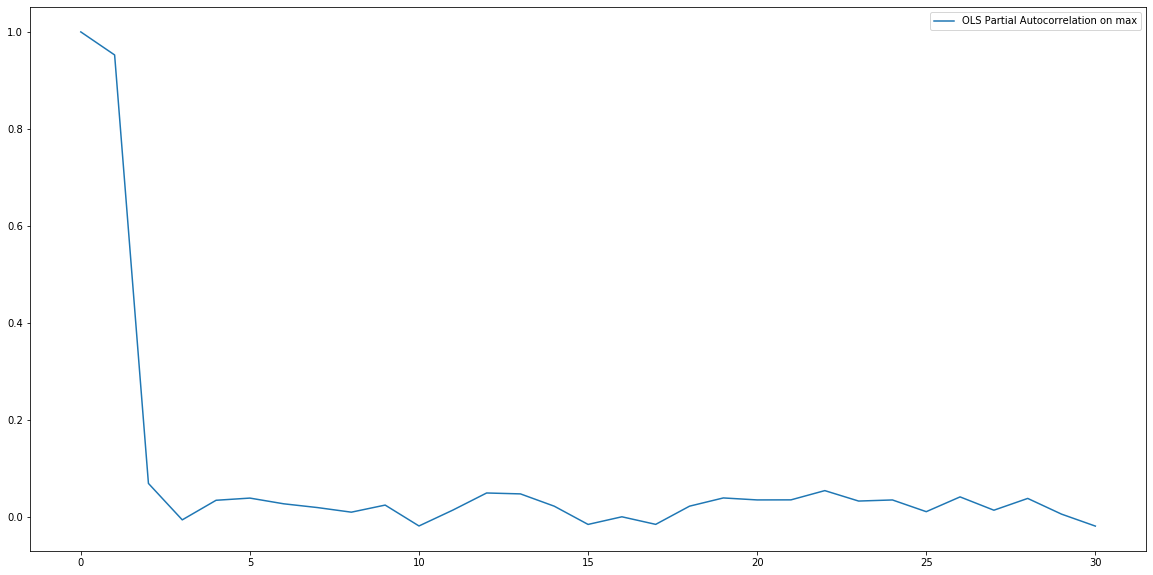

In [211]:
# Partial Autocorrelation using ordinary least squares (OLS) estimates for each lag instead of Yule-Walker.
plt.plot(pacf_ols(train_data, nlags=30), label='OLS Partial Autocorrelation on max')
plt.legend();

## Plotting
The arrays returned by <tt>.acf()</tt> and <tt>.pacf_yw()</tt> show the magnitude of the autocorrelation for a given $y$ at time $t$. let's look at the data itself for evidence of autocorrelation.

Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way:

In [212]:
from pandas.plotting import lag_plot

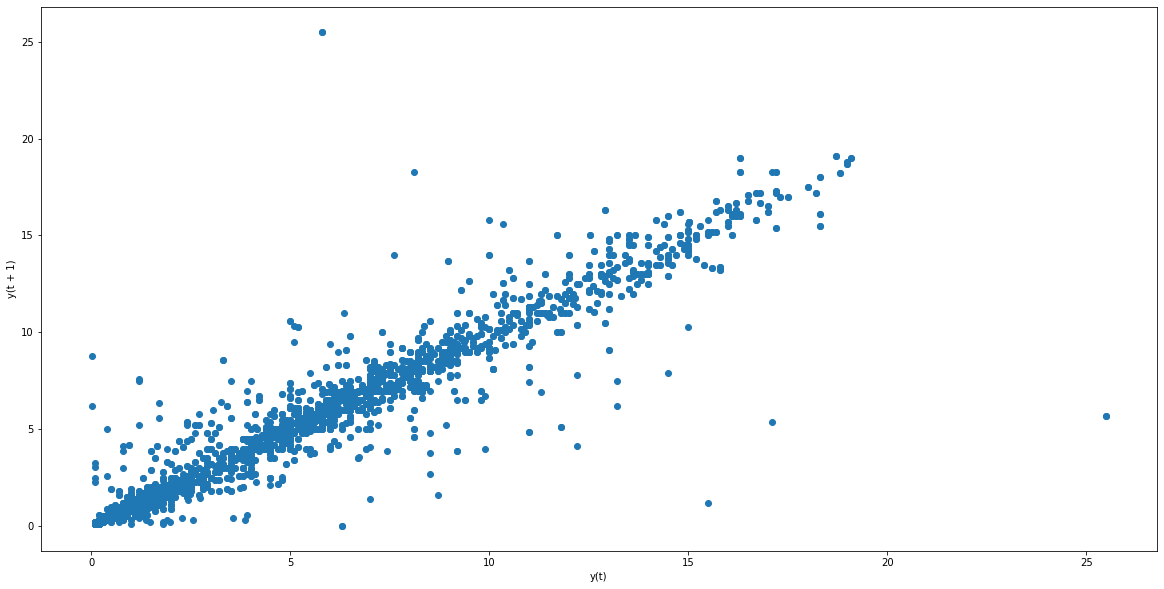

In [214]:
lag_plot(train_data);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

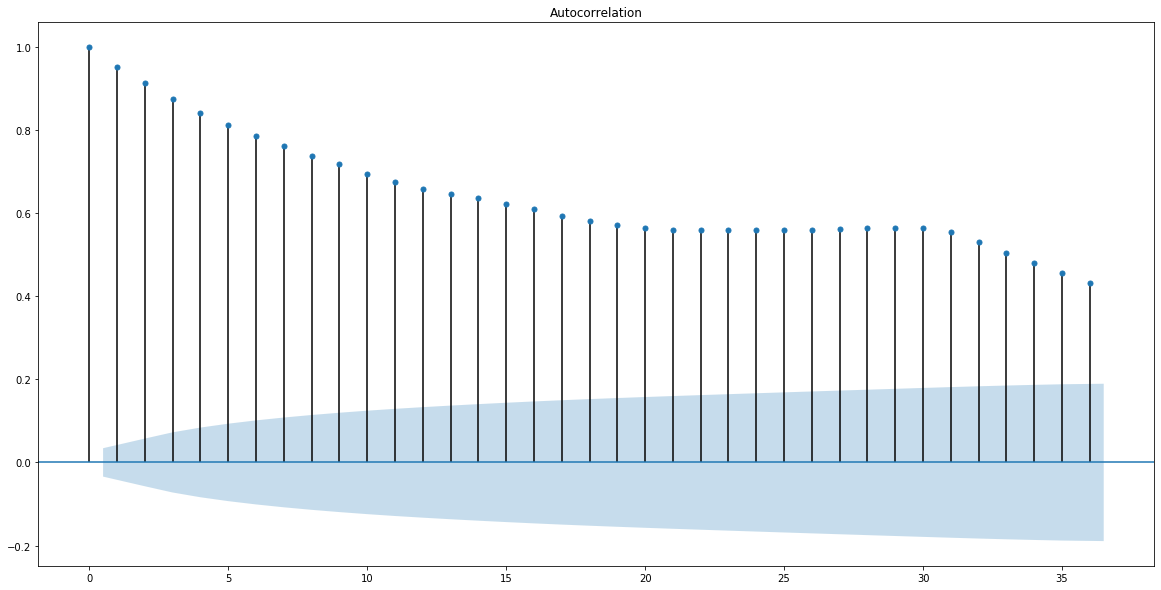

In [216]:
# Autocorrelation
plot_acf(train_data);

#### Both min and max values from 5 critical stations have gradual decline, not sharp drop, in their autocorelation plots which indicate the data is non-stationary  
1. The Autocorrelation plots show POSITIVE autocorrelation at the first lag (lag-1), then they suggest to use AR terms in the relation to the lag
2. If the Autocorrelation plots show NEGATIVE autocorrelation at the first lag, then they suggest to use MA terms in the relation to the lag

ACF is best for deciding MA models

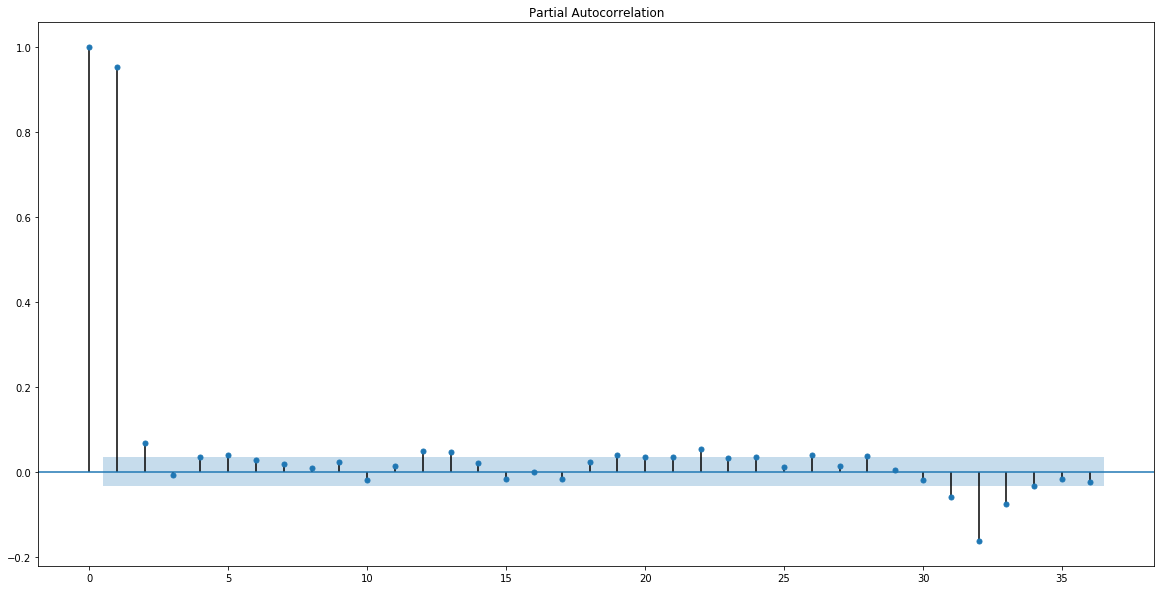

In [217]:
# Partial Autocorrelation
plot_pacf(train_data);

#### Both min and max values from 5 critical stations have sharp drop in their partial autocorelation plots  
1. Typically a sharp drop after lag k suggests an AR-k model should be used. PACF is best for deciding AR models
2. If there is an gradual decline, it suggests an MA model

In our case of these stations, k = 2 on AR models

## Samples for other stations could be used since they also have advantage due to lack of longer historical data. Further explorations are needed to pick the right prediction models  
See 'Principles and risks of forecasting' by Robert Nau  
Additional reading is preferable: https://people.duke.edu/~rnau/411home.htm